Integration of cardiomyocytes from NG (down-sampled) and Paige | Author: Xuezhu Sunny Wang

In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(pheatmap)

Warning message:
“package ‘Seurat’ was built under R version 4.2.3”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.2.3”
Loading required package: sp

Warning message:
“package ‘sp’ was built under R version 4.2.3”
‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


In [2]:
library(caret)
library(gelnet)

Loading required package: lattice



In [3]:
## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [4]:
run_highlight <- function(sce,sample_num,ptsize=2){
  myumap <- sce@reductions$umap@cell.embeddings %>%
    as.data.frame() %>%
    cbind(sample = sce@meta.data$orig.ident)
  all_sample = unique(myumap$sample)
  for (s in all_sample) {
    subumap <- myumap
    subumap$sample <- ifelse(subumap$sample==s,'yes','no')
    p = ggplot(subumap,aes(x= UMAP_1 , y = UMAP_2 ,color = sample)) +
      geom_point(size = ptsize , alpha =2,show.legend = F) +
      scale_color_manual(values = c('yes'='#D95F02','no'='grey65'))+
      labs(title = s)+
      theme_classic()+
      theme(axis.title = element_text(size = 15,colour = 'black'),
            axis.text = element_text(size = 12,colour = 'black'),
            plot.title = element_text(size = 20,colour = 'black',hjust = 0.5))
    ggsave(p,filename=paste0(sample_num,'_fig1_umap_highlight_',s,'.pdf'),width=7,height=7)
  }
}

In [5]:
load('CP23_no6_postQC_Cluster_res_0.4_noHarmony.RData')
ls()

[1] "StackedVlnPlot" "extract_max"    "modify_vlnplot" "pbmc"          
[5] "run_highlight"

In [6]:
pbmc@active.assay<-'RNA'
pbmc

An object of class Seurat 
27632 features across 16025 samples within 1 assay 
Active assay: RNA (27632 features, 2500 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [7]:
#pbmc<-subset(x = pbmc, downsample = 1000)
#pbmc

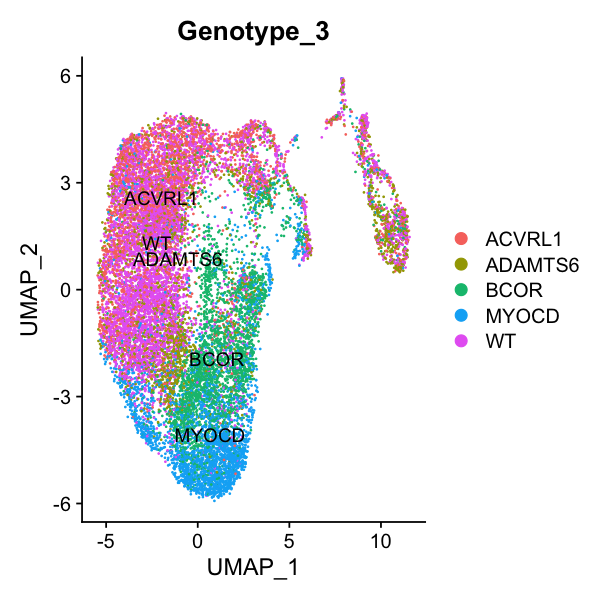

In [8]:
options(repr.plot.height=5,repr.plot.width=5)
p2 = DimPlot(pbmc,reduction = "umap", label = TRUE,group.by="Genotype_3")
p2

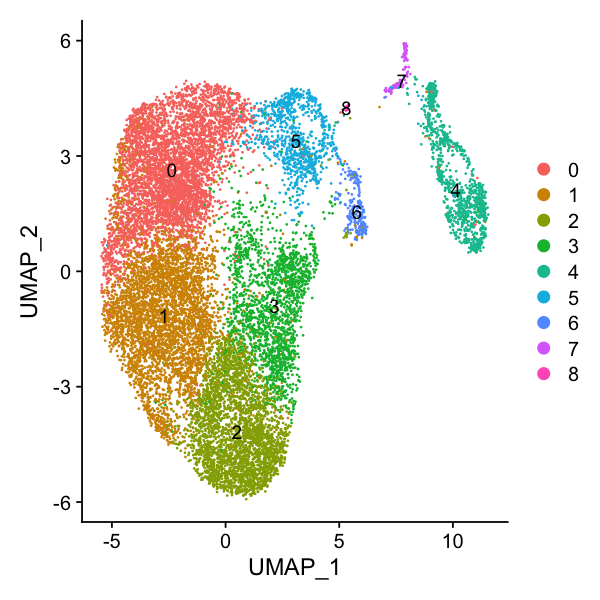

In [9]:
options(repr.plot.height=5,repr.plot.width=5)
p3 = DimPlot(pbmc,reduction = "umap", label = TRUE)
p3

In [10]:
#Idents(pbmc)<-'Genotype_3'

In [11]:
all.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
all.markers %>%
  group_by(cluster) %>%
  slice_max(n = 5, order_by = avg_log2FC)

Calculating cluster 0

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
2.343013e-275,2.045889,0.417,0.168,6.474212e-271,0,LRP1B
0.000000e+00,1.990224,0.528,0.197,0.000000e+00,0,CTB-174D11.1
8.675990e-204,1.978141,0.270,0.090,2.397350e-199,0,STXBP6
0.000000e+00,1.932910,0.410,0.145,0.000000e+00,0,LMO3
1.706033e-203,1.872888,0.299,0.110,4.714109e-199,0,RSPO3
2.145960e-240,1.635012,0.447,0.196,5.929717e-236,1,INPP4B
1.061731e-176,1.613343,0.277,0.098,2.933776e-172,1,CUX2
0.000000e+00,1.325027,0.698,0.357,0.000000e+00,1,DISC1
4.521782e-184,1.315693,0.550,0.321,1.249459e-179,1,EPHA4


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


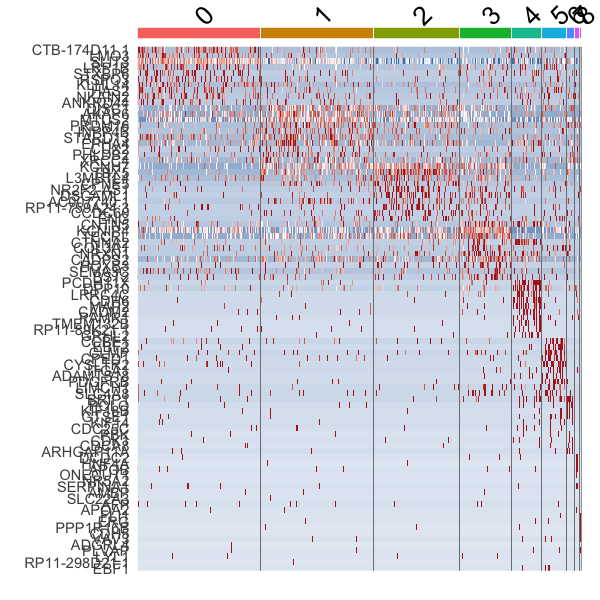

In [12]:
markers<-all.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
DoHeatmap(pbmc, features =markers$gene) + NoLegend() + scale_fill_gradientn(colors = c("steelblue", "white", "firebrick") )

In [13]:
sce1 <- readRDS('CM_after_reclustering.rds')
sce1

An object of class Seurat 
62959 features across 11058 samples within 2 assays 
Active assay: SCT (29161 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, tsne

In [14]:
genes<-rownames(GetAssayData(object = sce1, slot = 'data'))
features<-all.markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
features<-features$gene
use_features<-intersect(genes,features)

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


In [15]:
# data and labels 
labels <- pbmc$'seurat_clusters'
labels <- factor(labels, levels = c('0','1','2','3','4','5','6','7','8'))
use_data <- GetAssayData(object = pbmc, slot = 'data')[use_features,]

In [16]:
# generate training and testing datasets
idx <- createDataPartition(labels, p = 0.8, list = FALSE)
use_data_train <- use_data[,as.vector(idx)]
use_label_train <- labels[as.vector(idx)]
use_data_test <- use_data[,as.vector(-idx)]
use_label_test <- labels[as.vector(-idx)]

In [17]:
# training
for (title in unique(use_label_train)){
  use_train_stage <- as.matrix(use_data_train[,use_label_train==title])
  # train the model by one-class logistic regression classifier
  mm <- gelnet( t(use_train_stage), NULL, 0, 1 )
  df_oclr <- data.frame(w = mm$w)
  rownames(df_oclr) <- use_features
  write.table(df_oclr,paste0('./',title,'_marker_train.rds'),row.names = T, col.names =F)
  
}

Training a one-class model
Iteration 1 : f = 0.6931472 
Iteration 2 : f = 0.2559659 
Iteration 3 : f = 0.2212721 
Iteration 4 : f = 0.2211198 
Training a one-class model
Iteration 1 : f = 0.6931472 
Iteration 2 : f = 0.2496603 
Iteration 3 : f = 0.213805 
Iteration 4 : f = 0.2134754 
Training a one-class model
Iteration 1 : f = 0.6931472 
Iteration 2 : f = 0.2712479 
Iteration 3 : f = 0.2405808 
Iteration 4 : f = 0.2403952 
Training a one-class model
Iteration 1 : f = 0.6931472 
Iteration 2 : f = 0.247343 
Iteration 3 : f = 0.2069698 
Iteration 4 : f = 0.2066335 
Training a one-class model
Iteration 1 : f = 0.6931472 
Iteration 2 : f = 0.2625093 
Iteration 3 : f = 0.2248942 
Iteration 4 : f = 0.2244153 
Training a one-class model
Iteration 1 : f = 0.6931472 
Iteration 2 : f = 0.2416079 
Iteration 3 : f = 0.1891634 
Iteration 4 : f = 0.1882381 
Iteration 5 : f = 0.1882361 
Training a one-class model
Iteration 1 : f = 0.6931472 
Iteration 2 : f = 0.243073 
Iteration 3 : f = 0.1775493 
It

In [18]:
# testing
df_oclr <- as.data.frame(matrix(NA,nrow = ncol(use_data_test), ncol = 9))
titles <- c('0','1','2','3','4','5','6','7','8')
colnames(df_oclr) <- titles

In [19]:
for (title in titles){
  title_file <- title
  w_df <- read.table(paste0('./',title_file,'_marker_train.rds'),row.names = 1, header = F)
  use_data <- use_data_test[use_features,]
  w <- w_df[use_features,1]
  df_oclr[[title]] <- apply( use_data, 2, function(z) {cor( z, w, method="sp", use="complete.obs" )} )
  
}

In [20]:
colname <- colnames(df_oclr)
pred_type <- apply(df_oclr,1,function(z){colname[which.max(z)]})
pred_type <- factor(pred_type, levels = c('0','1','2','3','4','5','6','7','8'))

In [21]:
# testing data of confusion matrix
table(data.frame(truth = use_label_test,pred = pred_type))


     pred
truth   0   1   2   3   4   5   6   7   8
    0 741  79   7  32   3  24  10   2   3
    1  78 619 100  19   0   0  13   1   0
    2   1  68 505  43   0   0   6   0   0
    3  30  22  68 244   1   9   0   1   0
    4   6  11   7   5 172   4   4   3   0
    5  18   5   4   7   0 143   2   1   1
    6   1   4   1   0   1   2  42   0   0
    7   1   0   0   0   0   0   0  23   0
    8   0   0   0   0   0   0   0   0   5

In [23]:
# test on H2
H2.obj <- sce1
data <- GetAssayData(object = H2.obj,slot = 'data')
df_oclr <- as.data.frame(matrix(NA,nrow = dim(data)[2], ncol = 9))

titles <- c('0','1','2','3','4','5','6','7','8')
colnames(df_oclr) <- titles

In [24]:
for (title in titles){
  title_file <- title
  genes <-rownames(H2.obj)
    
  w_df <- read.table(paste0('./',title_file,'_marker_train.rds'),row.names = 1, header = F)
  
  use_genes <- intersect(genes,rownames(w_df))
  use_data <- data[use_genes,]
  w <- w_df[use_genes,1]
  
  df_oclr[[title]] <- apply( use_data, 2, function(z) {cor( z, w, method="sp", use="complete.obs" )})
  
}

In [25]:
colname <- colnames(df_oclr)
pred_type <- apply(df_oclr,1,function(z){colname[which.max(z)]})
pred_type <- factor(pred_type, levels = c('0','1','2','3','4','5','6','7','8'))
H2.obj <- AddMetaData(H2.obj,pred_type,'pred')


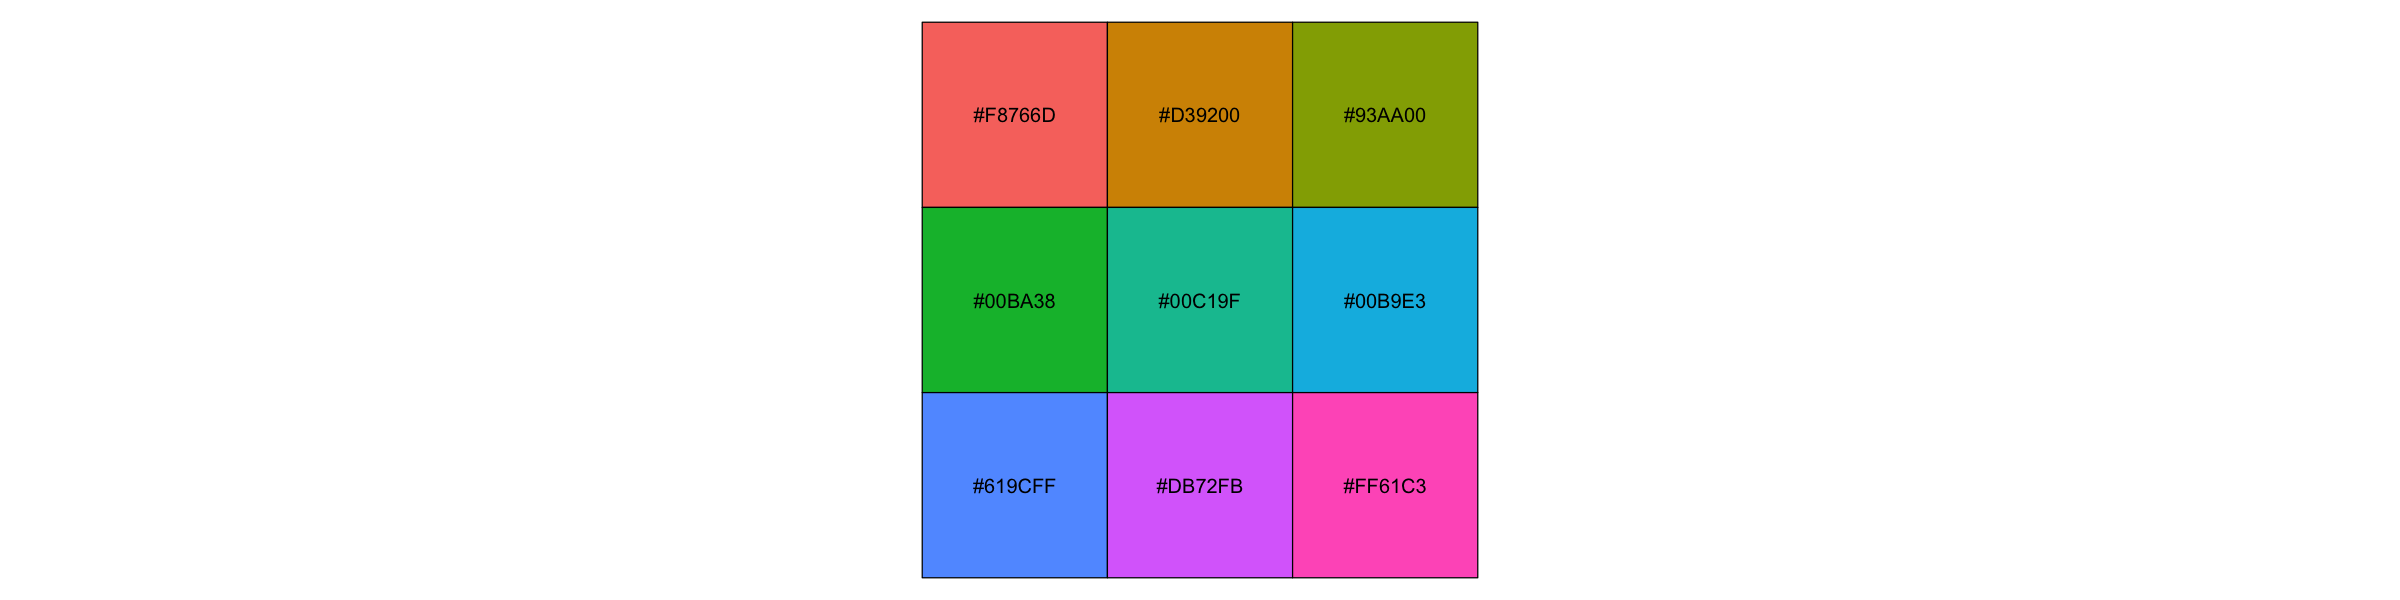

In [40]:
library(scales)
show_col(hue_pal()(9))

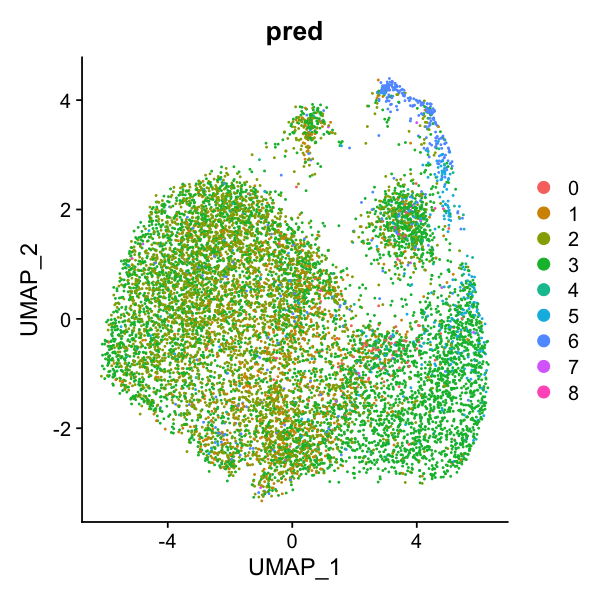

In [41]:
# UMAP showing the predicting results
options(repr.plot.height=5,repr.plot.width=5)
use_stage_colors <- hue_pal()(9)
p1 <- DimPlot(H2.obj,label = F,group.by = 'pred')+scale_color_manual(values = use_stage_colors)
print(p1)

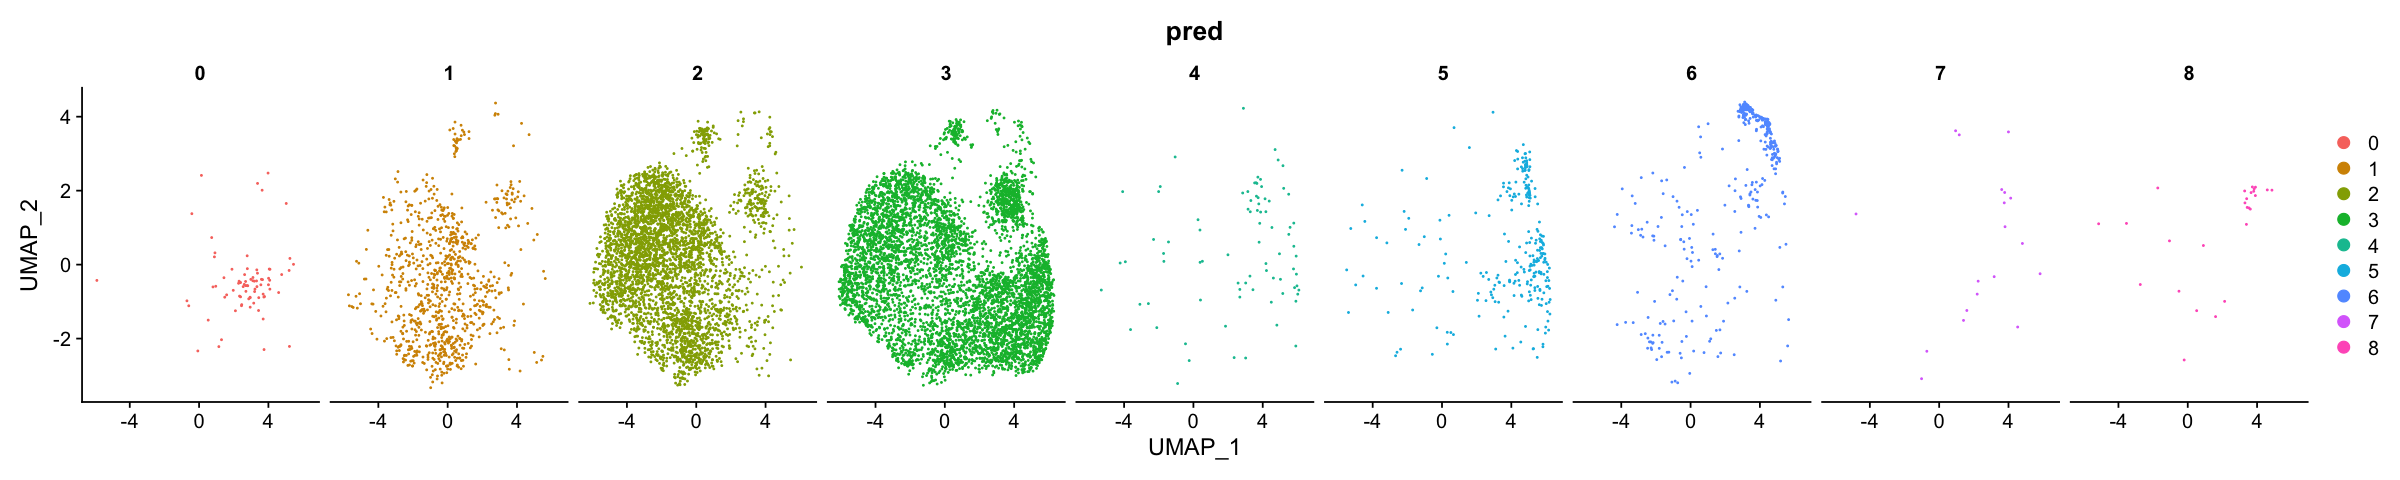

In [44]:
options(repr.plot.height=4,repr.plot.width=20)
p4 <- DimPlot(H2.obj,label = F,group.by = 'pred',split.by='pred')+scale_color_manual(values = use_stage_colors)
print(p4)

In [43]:
table(pred_type)

pred_type
   0    1    2    3    4    5    6    7    8 
  79  903 3764 5534   82  272  379   19   26 